In [1]:
#import all essential libraries
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.metrics import mean_squared_error,r2_score
## Deep-learing:
import tensorflow.keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.utils import np_utils
import itertools
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

https://www.kaggle.com/gurpreetmohaar/time-series-forecasting-using-lstm

In [2]:
data_folder = '/home/thomas/Documents/small_datasets/may_19/time_series/household_power_consumption.txt'

In [3]:
data = pd.read_csv(data_folder,sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, 
                   infer_datetime_format=True, 
                 low_memory=False, 
                   na_values=['nan','?'], 
                   index_col='dt')

In [4]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [5]:
data.describe()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [6]:
data.columns[data.isnull().any()]


Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

Check for linearity in each column through autocorrelation plots

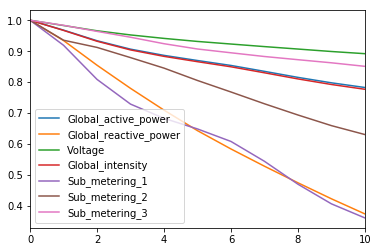

In [7]:
def get_acf(data,lags): 
    frame = []
    for i in range(lags+1):
        frame.append(data.apply(lambda col: col.autocorr(i), axis=0))
    return pd.DataFrame(frame).plot.line()
get_acf(data,10)

Fill missing values using linear interpolation with limit 10

In [8]:
clean_data = data.interpolate(method = 'linear', axis = 0, limit = 10)

# Plot the data

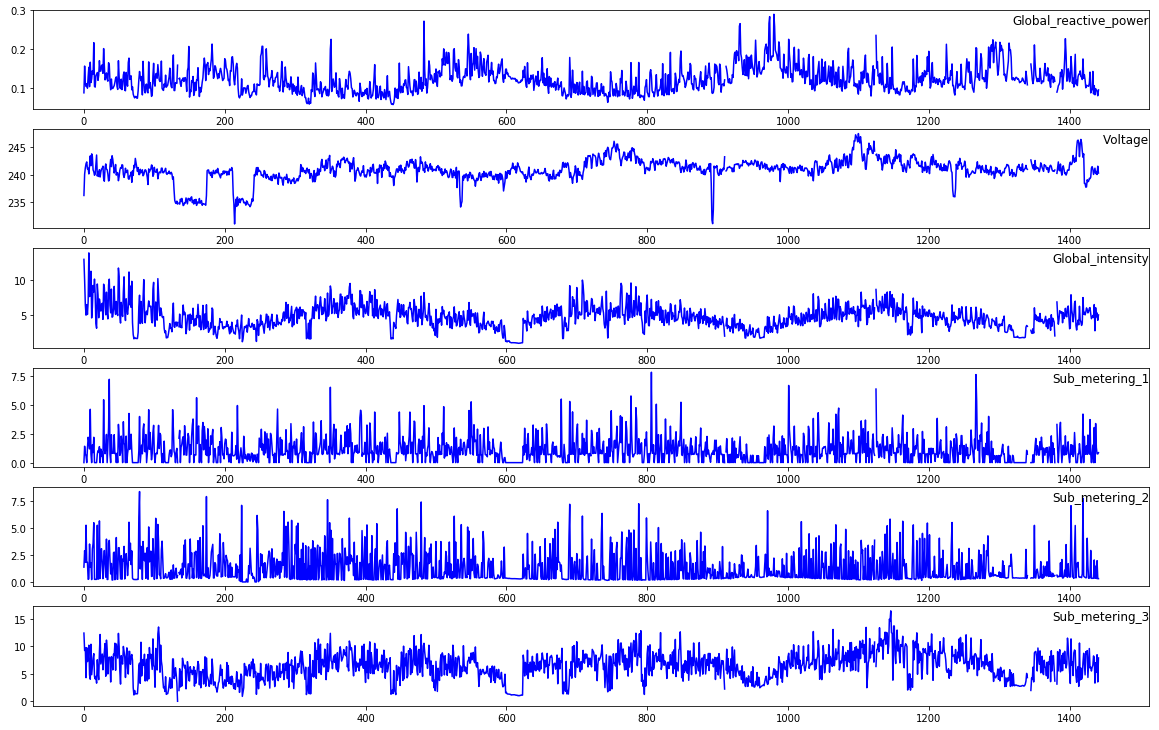

In [9]:
#Its imperative from autocorealtion plots that we dont need each minute data, perhaps we can decide roll up the aggregate
i = 1
# plot each column
plt.figure(figsize=(20, 15))
for counter in range(1,len(clean_data.columns)):
    plt.subplot(len(clean_data.columns), 1, i)
    plt.plot(clean_data.resample('D').mean().values[:, counter], color = 'blue')
    plt.title(clean_data.columns[counter], y=0.8, loc='right')
    i = i+1
plt.show()

In [10]:
#check corelation matrices for minute, hour and day
#minute
corr_min = clean_data.corr()
#hour
corr_hour = pd.DataFrame(clean_data.resample('H').mean().values).corr()
#day
corr_day = pd.DataFrame(clean_data.resample('D').mean().values).corr()
cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]


In [11]:
#Plot Minute
corr_min.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1,0.25,-0.4,1,0.48,0.43,0.64
Global_reactive_power,0.25,1,-0.11,0.27,0.12,0.14,0.09
Voltage,-0.4,-0.11,1,-0.41,-0.2,-0.17,-0.27
Global_intensity,1,0.27,-0.41,1,0.49,0.44,0.63
Sub_metering_1,0.48,0.12,-0.2,0.49,1,0.055,0.1
Sub_metering_2,0.43,0.14,-0.17,0.44,0.055,1,0.081
Sub_metering_3,0.64,0.09,-0.27,0.63,0.1,0.081,1


In [12]:
corr_hour.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,0,1,2,3,4,5,6
0,1,0.31,-0.38,1,0.5,0.44,0.7
1,0.31,1,-0.15,0.33,0.33,0.26,0.1
2,-0.38,-0.15,1,-0.39,-0.21,-0.16,-0.28
3,1,0.33,-0.39,1,0.5,0.45,0.69
4,0.5,0.33,-0.21,0.5,1,0.12,0.2
5,0.44,0.26,-0.16,0.45,0.12,1,0.12
6,0.7,0.1,-0.28,0.69,0.2,0.12,1


In [13]:
corr_day.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,0,1,2,3,4,5,6
0,1,0.039,0.11,1,0.54,0.47,0.73
1,0.039,1,-0.057,0.061,0.32,0.18,0.027
2,0.11,-0.057,1,0.087,-0.07,-0.078,0.17
3,1,0.061,0.087,1,0.55,0.48,0.72
4,0.54,0.32,-0.07,0.55,1,0.25,0.3
5,0.47,0.18,-0.078,0.48,0.25,1,0.2
6,0.73,0.027,0.17,0.72,0.3,0.2,1


In [14]:
#drop highly corelated columns 

clean_data = clean_data.drop(columns = ['Global_intensity'])

In [15]:
#Credit: Adopted from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [16]:
clean_data_play_around = clean_data.copy()

In [17]:
clean_data_play_around.head()

,Global_active_power,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,0.0,1.0,17.0


In [18]:
#clean_data_play_around.shift(2).head()

In [19]:
playaround = series_to_supervised(clean_data_play_around)

In [20]:
playaround.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
dt,,,,,,,,,,,,
2006-12-16 17:25:00,4.216,0.418,234.84,0.0,1.0,17.0,5.360,0.436,233.63,0.0,1.0,16.0
2006-12-16 17:26:00,5.360,0.436,233.63,0.0,1.0,16.0,5.374,0.498,233.29,0.0,2.0,17.0
2006-12-16 17:27:00,5.374,0.498,233.29,0.0,2.0,17.0,5.388,0.502,233.74,0.0,1.0,17.0
2006-12-16 17:28:00,5.388,0.502,233.74,0.0,1.0,17.0,3.666,0.528,235.68,0.0,1.0,17.0
2006-12-16 17:29:00,3.666,0.528,235.68,0.0,1.0,17.0,3.520,0.522,235.02,0.0,2.0,17.0


In [21]:
playaround.shape, clean_data_play_around.shape

((2049496, 12), (2075259, 6))

In [22]:
#framing the problem
#resample over day

## resampling of data over hour
resampled_data = clean_data.resample('H').mean() 
resampled_data.shape

(34589, 6)

In [23]:
#normalised_data=(resampled_data-resampled_data.min())/(resampled_data.max()-resampled_data.min())
#print(normalised_data.head())

In [24]:
# Feature engineering for LSTM
reframed_data = series_to_supervised(resampled_data, 1, 1)
reframed_data.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
dt,,,,,,,,,,,,
2006-12-16 18:00:00,4.222889,0.229000,234.643889,0.0,0.527778,16.861111,3.632200,0.080033,234.580167,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.632200,0.080033,234.580167,0.0,6.716667,16.866667,3.400233,0.085233,233.232500,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.400233,0.085233,233.232500,0.0,1.433333,16.683333,3.268567,0.075100,234.071500,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.268567,0.075100,234.071500,0.0,0.000000,16.783333,3.056467,0.076667,237.158667,0.0,0.416667,17.216667
2006-12-16 22:00:00,3.056467,0.076667,237.158667,0.0,0.416667,17.216667,2.200133,0.056167,238.760000,0.0,0.133333,4.433333


In [25]:
reframed_data.shape

(34163, 12)

In [26]:
# drop columns we don't want
reframed_data.drop(reframed_data.columns[[5,7,8,9,10,11]], axis=1, inplace=True)
print(reframed_data.columns)

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var1(t)'],
      dtype='object')


In [27]:
reframed_data.shape

(34163, 6)

In [28]:
# split into train and test sets
values = reframed_data.values
train_index = 500*24 #The logic is to have 500 days worth of training data. this could also be a hyperparameter that can be tuned.
train = values[:train_index, :]
test = values[train_index:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(12000, 1, 5) (12000,) (22163, 1, 5) (22163,)


In [29]:
a = np.array([[1,2,3,4],[5,6,7,8]])

In [30]:
a[:,:-1], a[:,-1]

(array([[1, 2, 3],
        [5, 6, 7]]), array([4, 8]))

In [41]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Dropout(0.2))
model.add(LSTM(50, dropout = 0.2))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [42]:
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=20, validation_data=(test_X, test_y), verbose=1, shuffle=False)


Train on 12000 samples, validate on 22163 samples
Epoch 1/10
12000/12000 [==============================] - 5s 455us/sample - loss: 0.9632 - val_loss: 0.6199
Epoch 2/10
12000/12000 [==============================] - 4s 313us/sample - loss: 0.8277 - val_loss: 0.5294
Epoch 3/10
12000/12000 [==============================] - 4s 308us/sample - loss: 0.6762 - val_loss: 0.4860
Epoch 4/10
12000/12000 [==============================] - 4s 317us/sample - loss: 0.5773 - val_loss: 0.4520
Epoch 5/10
12000/12000 [==============================] - 4s 321us/sample - loss: 0.5483 - val_loss: 0.4267
Epoch 6/10
12000/12000 [==============================] - 4s 317us/sample - loss: 0.5316 - val_loss: 0.3942
Epoch 7/10
12000/12000 [==============================] - 4s 324us/sample - loss: 0.5130 - val_loss: 0.3970
Epoch 8/10
12000/12000 [==============================] - 4s 335us/sample - loss: 0.5156 - val_loss: 0.4018
Epoch 9/10
12000/12000 [==============================] - 4s 329us/sample - loss: 0.51

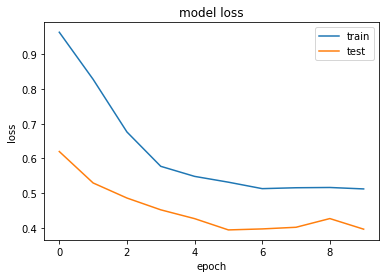

In [43]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [44]:
# make a prediction
yhat = model.predict(test_X, verbose=0)
rmse = np.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.630


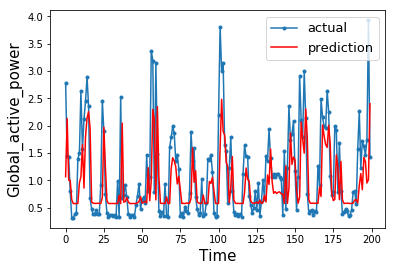

In [45]:
## time steps, every step is one hour (you can easily convert the time step to the actual time index)
## for a demonstration purpose, I only compare the predictions in 200 hours. 

aa=[x for x in range(200)]
plt.plot(aa, test_y[:200], marker='.', label="actual")
plt.plot(aa, yhat[:200], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time', size=15)
plt.legend(fontsize=13)
plt.show()